In [17]:
from matplotlib.pyplot import *
import numpy as np
import pandas as pd
import os
import importlib


from ATARI.sammy_interface import sammy_interface, sammy_classes, sammy_functions, template_creator

from ATARI.ModelData.particle_pair import Particle_Pair

from ATARI.ModelData.experimental_model import Experimental_Model

from copy import copy


In [18]:
%matplotlib widget

## Measurement Data

The following measurement data are imported from the work of Jesse Brown at RPI (currently at ORNL).
These measurements are detailed in https://www.tandfonline.com/doi/full/10.1080/00295639.2023.2249786 and consist of 6 experimental configurations.
Of the 4 transmission measurements only 3 are used for evaluation and the 4th (45m FP) is used for validation. 
Both 2 capture measurements are used in evaluation.

The transmission data are reliable in the range 0.15-100 keV.
The capture data are reliable from 0.15-200 keV. 



In [19]:
### Determine channel widths
from ATARI.theory.experimental import e_to_t, t_to_e

def get_chw_and_upperE(E, FP):
    E = np.array(E)
    tof = e_to_t(E, FP, True)
    dt = np.diff(tof*1e6)
    widths1, index1 = np.unique(np.round(dt, 4), return_index=True)
    chw, Emax = np.flipud(widths1), np.flipud(E[index1])
    strc = ''
    stre = ''
    for c,e in zip(chw, Emax):
        strc += f"{c*1e3:.2f}, "
        stre += f"{e:.2f}, "
    return stre, strc

# Emax, chw = get_chw_and_upperE(transdat6.E, 100.14)
# Emax, chw = get_chw_and_upperE(capdat1.E, 45.27)
# print(Emax)
# print(chw)
# energy_range_all = [150, 6000]
energy_range_all = [201, 228]

In [20]:
### 1mm capture data
capdat1 = sammy_functions.readlst("./yield_ta1b_unsmooth.dat")
expcap1 = Experimental_Model(title = "cap1mm",
                                reaction ="capture", 
                                energy_range = energy_range_all,
                                n = (0.005631, 0),
                                FP = (45.27, 0.05),
                                burst= (8.0,1.0), 
                                temp= (294.2610, 0.0),
                                channel_widths={
                                    "maxE": [68.20,  122.68, 330.48, 547.57, 199359.52], 
                                    "chw":  [821.40, 410.70, 102.70, 51.30,  25.70],
                                    "dchw": [0.8,    0.8,    0.8,    0.8,    0.8]
                                }
                               )
capdat1 = capdat1[(capdat1.E<max(expcap1.energy_range)) & (capdat1.E>min(expcap1.energy_range))]


### 2mm capture data
capdat2 = sammy_functions.readlst("./yield_ta2_unsmooth.dat")
expcap2 = Experimental_Model(   title = "cap2mm",
                                reaction = "capture", 
                                energy_range = energy_range_all,
                                n = (0.011179, 0.0),
                                FP = (45.27, 0.05),
                                burst = (8.0,1.0),
                                temp = (294.2610, 0.0),
                                channel_widths={
                                    "maxE": [68.20,  122.68, 330.48, 547.57, 199359.52], 
                                    "chw":  [821.40, 410.70, 102.70, 51.30,  25.70],
                                    "dchw": [0.8,    0.8,    0.8,    0.8,    0.8]
                                }
                               )
capdat2 = capdat2[(capdat2.E<max(expcap2.energy_range)) & (capdat2.E>min(expcap2.energy_range))]


### 1mm Transmission data
transdat1 = sammy_functions.readlst("./trans-Ta-1mm.twenty")
transdat1_covfile = './trans-Ta-1mm.idc'
chw, Emax = get_chw_and_upperE(transdat1.E, 100.14)
exptrans1 = Experimental_Model(title = "trans1mm",
                               reaction = "transmission", 
                               energy_range = energy_range_all,

                                n = (0.00566,0.0),  
                                FP = (100.14,0.0), 
                                burst = (8, 0.0), 
                                temp = (294.2610, 0.0),

                               channel_widths={
                                    "maxE": [216.16, 613.02, 6140.23], 
                                    "chw": [204.7, 102.4, 51.2],
                                    "dchw": [1.6, 1.6, 1.6]
                                }
                                
                               )
transdat1 = transdat1[(transdat1.E<max(exptrans1.energy_range)) & (transdat1.E>min(exptrans1.energy_range))]

### 3mm transmission data
transdat3 = sammy_functions.readlst("./trans-Ta-3mm.twenty")
transdat3_covfile = "./trans-Ta-3mm.idc"
exptrans3 = Experimental_Model(title = "trans3mm",
                               reaction = "transmission", 
                               energy_range = energy_range_all,

                                n = (0.017131,0.0),  
                                FP = (100.14,0.0), 
                                burst = (8, 0.0), 
                                temp = (294.2610, 0.0),

                               channel_widths={
                                    "maxE": [216.16, 613.02, 6140.23], 
                                    "chw": [204.7, 102.4, 51.2],
                                    "dchw": [1.6, 1.6, 1.6]
                                }
                                
                               )
transdat3 = transdat3[(transdat3.E<max(exptrans3.energy_range)) & (transdat3.E>min(exptrans3.energy_range))]


### 6mm transmission data
transdat6 = sammy_functions.readlst("./trans-Ta-6mm.twenty")
transdat6_covfile = "./trans-Ta-6mm.idc"
exptrans6 = Experimental_Model(title = "trans6mm",
                               reaction = "transmission", 
                               energy_range = energy_range_all,

                                n = (0.03356,0.0),  
                                FP = (100.14,0.0), 
                                burst = (8, 0.0), 
                                temp = (294.2610, 0.0),

                               channel_widths={
                                    "maxE": [216.16, 613.02, 6140.23], 
                                    "chw": [204.7, 102.4, 51.2],
                                    "dchw": [1.6, 1.6, 1.6]
                                }
                                
                               )
transdat6 = transdat6[(transdat6.E<max(exptrans6.energy_range)) & (transdat6.E>min(exptrans6.energy_range))]


### Not using 12mm measurement for evaluation - this is a validation measurement

# transdat12 = sammy_functions.readlst("/Users/noahwalton/research_local/resonance_fitting/ATARI_workspace/measurement_data/trans-Ta-12mm.dat")
# # transdat12_covfile = Need to generate from sys and stat covariances
# exptrans12 = Experimental_Model(title = "trans12",
#                                 reaction = "transmission",
#                                 energy_range = erange_all,

#                                 sammy_inputs = {
#                                     'alphanumeric'       :   ["BROADENING IS WANTED"],
#                                     'ResFunc'            :   "ORRES"
#                                         },

#                                 n = (0.067166, 0.0),  
#                                 FP = (35.185,0.0), 
#                                 burst = (8,0.0), 
#                                 temp = (294.2610, 0.0),

#                                 channel_widths={
#                                         "maxE": [270], 
#                                         "chw": [102.7],
#                                         "dchw": [0.8]
#                                         },

#                                 additional_resfunc_lines=["WATER 0004 5.6822000 -0.54425 0.07733000", "WATER      0.5000000  0.05000 0.00700000", "LITHI 000  -1.000000  -1.0000 6.00000000", "LITHI      0.1000000  0.10000 0.60000000", "LITHI      166.87839 -28.7093 1.260690", "LITHI      0.2574580 -0.06871 0.004915"]
#                                )

# transdat12 = transdat12[(transdat12.E<max(exptrans12.energy_range)) & (transdat12.E>min(exptrans12.energy_range))]


In [21]:
### plotting function

# plotting data & fits
# default fig size to output
fig_size = (8,6)

# if we will save images - where to save
savefolder = 'anim_create/'
if not os.path.exists(savefolder):
    # If it doesn't exist, create it
    os.makedirs(savefolder)

def plot_datafits(datasets, experiments, 
    fits=[], fits_chi2=[],
    priors=[], priors_chi2=[],
    true=[], true_chi2=[],
    true_pars = pd.DataFrame(), 
    prior_pars = pd.DataFrame(),
    fit_pars = pd.DataFrame(),
    title: str = '',
    show_spingroups: bool = True,
    fig_size : tuple = (8,6)
    ):

    colors = ["C1", "C2", "C3", "C4", "C5", "C6", "C7"]
    fig, axes = subplots(2,1, figsize=fig_size, sharex=True)

    for i, exp in enumerate(experiments):
        if exp.reaction == "transmission":
            model_key = "theo_trans"
            iax = 0
        elif exp.reaction == "capture":
            model_key = "theo_xs"
            iax = 1
        else:
            raise ValueError()

        axes[iax].errorbar(datasets[i].E, datasets[i].exp, yerr=datasets[i].exp_unc, zorder=0,
                                                fmt='.', color='black', alpha=0.5, linewidth=1.0, markersize=4, capsize=1, label=exp.title)
        
        if len(fits) != 0:
            if (len(fits_chi2) != 0):
                fit_label = f'fit {exp.title} ({fits_chi2[i]})'
            else:
                fit_label = f'fit {exp.title}'
            axes[iax].plot(fits[i].E, fits[i][model_key], color='red', zorder=1, lw=1.5, label=fit_label) # colors[i]
        
        if len(priors) != 0:
            if (len(priors_chi2) != 0):
                prior_label = f'prior {exp.title} ({priors_chi2[i]})'
            else:
                prior_label = f'prior {exp.title}'

            axes[iax].plot(priors[i].E, priors[i][model_key], '--', color='orange', zorder=0, lw=1.5, label=prior_label)
        
        if len(true) != 0:
            if (len(true_chi2) != 0):
                true_label = f'JEFF {exp.title} ({true_chi2[i]})'
            else:
                true_label = f'JEFF {exp.title}'
            axes[iax].plot(true[i].E, true[i][model_key], '-', color='green', zorder=1, alpha=0.5, lw=1.5, label=true_label)


    # Set the y-axis limits with additional space for text and capture ymax before changing
    
    y_top_padding = 0.1 
    x_offset = 0.05

    ymax_values = [ax.get_ylim()[1] for ax in axes]  # Store original ymax values for each axis
    for ax in axes:
        ymin, ymax = ax.get_ylim()
        ax.set_ylim(ymin, ymax + y_top_padding)

    font_size = 8
    y_text_shift = 0.01  # Adjust as needed, related to font size
    y_text_positions = [ymax_values[0], ymax_values[1]]

    # show vertical lines for energies
    
    # fits
    for index, res in fit_pars.iterrows():
        res_E = res.E
        # Add vertical lines at the resonance energies to both subplots
        axes[0].axvline(x=res_E, color='red', linestyle='--', linewidth=0.5, alpha=0.3)
        axes[1].axvline(x=res_E, color='red', linestyle='--', linewidth=0.5, alpha=0.3)

        if (show_spingroups):
            # add txt with
            sp_gr_txt = np.round(int(res.J_ID),0)
            
            y_text_position = ymax  # Position the text at the top of the original y-axis limit
            x_text_position = res_E + x_offset
            
            # Show the text to the right of the line
            for i, ax in enumerate(axes):
                y_text_position = ymax_values[i]  # Use original ymax for text position
                #ax.text(x_text_position, y_text_position, str(sp_gr_txt), color='red', verticalalignment='bottom', fontsize=8)

                ax.text(res_E, y_text_positions[i], str(sp_gr_txt), color='red', verticalalignment='bottom', fontsize=font_size)
                y_text_positions[i] -= y_text_shift


    # the same for theoretical positions
    for index, true_res in true_pars.iterrows():

        true_res_energy = true_res.E
        # Add vertical lines at the resonance energies to both subplots
        axes[0].axvline(x=true_res_energy, color='g', linestyle='--', linewidth=0.5, alpha=0.7)
        axes[1].axvline(x=true_res_energy, color='g', linestyle='--', linewidth=0.5, alpha=0.7)

        if (show_spingroups):
            # add txt with
            sp_gr_txt = np.round(true_res.J_ID,0)
            y_text_position = ymax  # Position the text at the top of the original y-axis limit
            x_text_position = true_res_energy
            
            # Show the text to the right of the line
            for i, ax in enumerate(axes):
                y_text_position = ymax_values[i]  # Use original ymax for text position
                ax.text(x_text_position , y_text_position, str(sp_gr_txt), color='g', verticalalignment='bottom', fontsize=8)

    
    for index, res in prior_pars.iterrows():
        # Add vertical lines at the resonance energies to both subplots
        axes[0].axvline(x=res.E, color='orange', linestyle='--', linewidth=0.5, alpha=0.5)
        axes[1].axvline(x=res.E, color='orange', linestyle='--', linewidth=0.5, alpha=0.5)

        
    axes[0].set_ylabel("T")
    axes[1].set_ylabel(r"$Y_{\gamma}$")

    # set title
    fig.suptitle(title, fontsize=14)
    
    # additional info if present
    add_title = ''
    if (true_pars.shape[0]>0):
        add_title+=''+r'$N_{true}$ = '+str(true_pars.shape[0])
        
    if (len(true_chi2)>0):
        add_title+=', $\sum_{ds}\chi^2$ = '+str(np.round(np.sum(true_chi2),3))

    if (prior_pars.shape[0]>0):
        add_title+=', '+r'$N_{prior}$ = '+str(prior_pars.shape[0])
    if (len(priors_chi2)>0):
        add_title+=', $\sum_{ds}\chi^2$ = '+str(np.round(np.sum(priors_chi2),3))

    if (fit_pars.shape[0]>0):
        add_title+=', '+r'$N_{fit}$ = '+str(fit_pars.shape[0])
    if (len(fits_chi2)>0):
        add_title+=', $\sum_{ds}\chi^2$ = '+str(np.round(np.sum(fits_chi2),3))
    
    # end additional info if present
    axes[0].set_title(add_title, fontsize=10)
    

    # ### make it pretty
    for ax in axes:
        # ax.set_xlim([200,250])
        # ax.set_ylim([-0.1,1.1])
        ax.legend(fontsize='small', loc='lower right')

    fig.supxlabel('Energy (eV)')
    fig.tight_layout()

    return fig

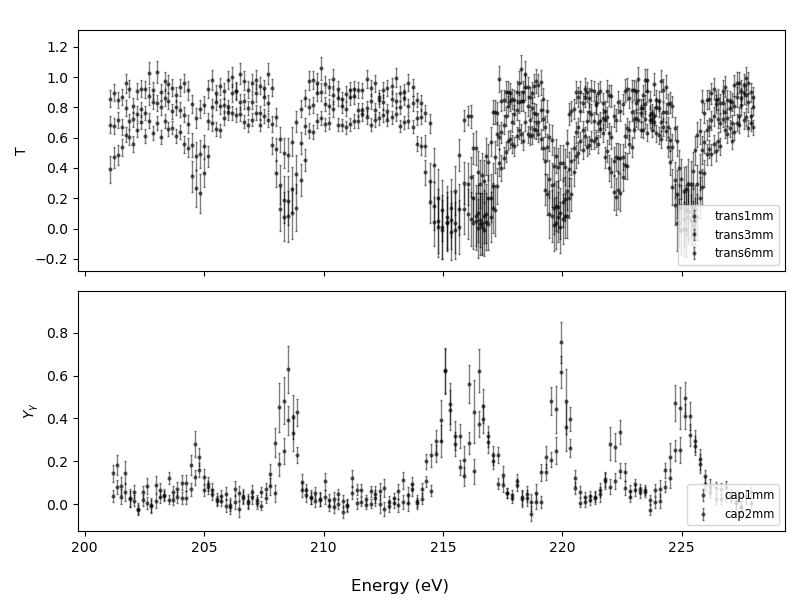

In [22]:
### setup in zipped lists 
datasets = [capdat1, capdat2, transdat1, transdat3, transdat6]
experiments= [expcap1, expcap2, exptrans1, exptrans3, exptrans6]
covariance_data = [{}, {}, transdat1_covfile, transdat3_covfile, transdat6_covfile]
templates = []
for data, exp in zip(datasets, experiments):
    filepath = f'template_{exp.title}_edited'
    exp.template = os.path.realpath(filepath)



fig = plot_datafits(datasets, experiments, 
    # true_pars = true_ladder, 
    prior_pars = pd.DataFrame(),
)

fig.tight_layout()


## Fit from ENDF or JEFF

In [23]:
sammyRTO = sammy_classes.SammyRunTimeOptions('/Users/noahwalton/gitlab/sammy/sammy/build/bin/sammy',
                             {"Print"   :   True,
                              "bayes"   :   False,
                              "keep_runDIR"     : True
                              })

matnum = 7328

# endf_file = "/Users/noahwalton/research_local/data/neutrons_ENDF-B-VII.1/n-073_Ta_181.endf"
# endf_parameters = sammy_functions.get_endf_parameters(endf_file, matnum, sammyRTO)

# endf_parameters = endf_parameters[(endf_parameters.E<260) & (endf_parameters.E>190)]
# endf_parameters["varyGn1"] = np.ones(len(endf_parameters))
# endf_parameters["varyGg"] = np.ones(len(endf_parameters))*0
# endf_parameters["varyE"] = np.ones(len(endf_parameters))

jeff_file = "./73-Ta-181g.jeff33"
jeff_parameters = sammy_functions.get_endf_parameters(jeff_file, matnum, sammyRTO)

jeff_parameters = jeff_parameters[(jeff_parameters.E<np.max(energy_range_all)) & (jeff_parameters.E>np.min(energy_range_all))]
jeff_parameters["varyGn1"] = np.ones(len(jeff_parameters))
jeff_parameters["varyGg"] = np.ones(len(jeff_parameters))*1
jeff_parameters["varyE"] = np.ones(len(jeff_parameters))
jeff_parameters

,E,Gg,Gn1,varyE,varyGg,varyGn1,J_ID
48,204.67,64.9999,2.754,1.0,1.0,1.0,1.0
49,208.48,64.9999,9.422,1.0,1.0,1.0,2.0
50,215.09,64.9999,48.270,1.0,1.0,1.0,2.0
51,216.60,64.9999,19.390,1.0,1.0,1.0,1.0
52,219.81,64.9999,12.880,1.0,1.0,1.0,2.0
53,222.29,64.9999,2.436,1.0,1.0,1.0,2.0
54,225.15,64.9999,20.570,1.0,1.0,1.0,2.0


In [24]:

Ta_pair = Particle_Pair(isotope="Ta181",
                        formalism="XCT",
                        ac=8.1271,     # scattering radius
                        M=180.948030,  # amu of target nucleus
                        m=1,           # amu of incident neutron
                        I=3.5,         # intrinsic spin, positive parity
                        i=0.5,         # intrinsic spin, positive parity
                        l_max=2)       # highest order l-wave to consider

Ta_pair.add_spin_group(Jpi='3.0',
                       J_ID=1,
                       D_avg=8.79,
                       Gn_avg=46.5,
                       Gn_dof=1,
                       Gg_avg=64.0,
                       Gg_dof=1000)

Ta_pair.add_spin_group(Jpi='4.0',
                       J_ID=2,
                       D_avg=4.99,
                       Gn_avg=35.5,
                       Gn_dof=1,
                       Gg_avg=64.0,
                       Gg_dof=1000)


rto = sammy_classes.SammyRunTimeOptions('/Users/noahwalton/gitlab/sammy/sammy/build/bin/sammy',
                             {"Print"   :   True,
                              "bayes"   :   True,
                              "keep_runDIR"     : True,
                              "sammy_runDIR": "sammy_runDIR_1"
                              })


sammyINPyw = sammy_classes.SammyInputDataYW(
    particle_pair = Ta_pair,
    resonance_ladder = jeff_parameters,  

    datasets= datasets,
    experiments = experiments,
    experimental_covariance= covariance_data, 
    
    max_steps = 10,
    iterations = 2,
    step_threshold = 0.1,
    autoelim_threshold = None,

    LS = False,
    LevMar = True,
    LevMarV = 2,
    LevMarVd= 5,
    initial_parameter_uncertainty = 0.01
    )



In [25]:
sammyOUT = sammy_functions.run_sammy_YW(sammyINPyw, rto)

Stepping until convergence
chi2 values
step fudge: ['cap1mm', 'cap2mm', 'trans1mm', 'trans3mm', 'trans6mm', 'sum']
0    0.01 : [2.2126, 2.2413, 1.0965, 1.9264, 3.8534, 11.3302]
1    0.02 : [1.8906, 2.1726, 0.9705, 1.631, 3.3972, 10.0619]
2    0.04 : [1.8525, 2.1352, 0.9409, 1.6088, 3.3077, 9.8451]
3    0.08 : [1.7954, 2.0752, 0.9146, 1.6005, 3.2136, 9.5994]
4    0.16 : [1.7276, 2.0087, 0.9192, 1.6151, 3.1875, 9.4582]
5    0.32 : [1.6254, 1.9238, 0.9438, 1.6172, 3.1944, 9.3046]
6    0.64 : [1.5734, 1.8791, 0.9595, 1.6094, 3.1878, 9.2092]
Chi2 improvement below threshold


In [26]:
# prior_lsts = lsts
print(sammyOUT.chi2n, np.sum(sammyOUT.chi2n))
print(sammyOUT.chi2n_post, np.sum(sammyOUT.chi2n_post))

print(sammyOUT.chi2, np.sum(sammyOUT.chi2))
print(sammyOUT.chi2_post, np.sum(sammyOUT.chi2_post))

[2.21262, 2.24133, 1.0965, 1.92644, 3.85335] 11.33024
[1.57342, 1.8791, 0.959536, 1.60935, 3.18782] 9.209226
[303.129, 307.062, 236.844, 416.111, 832.324] 2095.4700000000003
[215.559, 257.437, 207.26, 347.619, 688.568] 1716.443


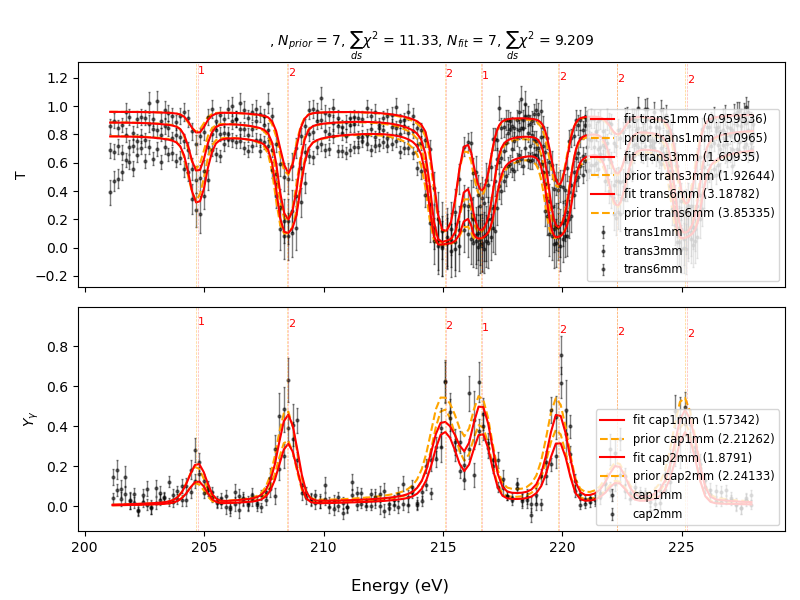

In [27]:
fig = plot_datafits(datasets, experiments, 
    fits=sammyOUT.pw_post,
    fit_pars=sammyOUT.par_post,
    fits_chi2=sammyOUT.chi2n_post,
    priors=sammyOUT.pw,
    prior_pars = sammyOUT.par,
    priors_chi2= sammyOUT.chi2n
)

fig.tight_layout()

## AutoFit

In [28]:
from ATARI.AutoFit.initial_FB_solve import InitialFB, InitialFBOPT

sammy_rto_fit = sammy_classes.SammyRunTimeOptions('/Users/noahwalton/gitlab/sammy/sammy/build/bin/sammy',
                                        {"Print":   True,
                                         "bayes":   True,
                                         "keep_runDIR": True,
                                         "sammy_runDIR": "sammy_runDIR"
                                         })


options = InitialFBOPT(Gn_threshold=1e-2,
                       iterations=3,
                       max_steps = 30,
                       step_threshold=0.01,
                       LevMarV0=0.05,
                       fit_all_spin_groups=False,
                       spin_group_keys = ['3.0'])

autofit_initial = InitialFB(options)

In [29]:
outs = autofit_initial.fit(Ta_pair,
                            #    [200,230],
                           energy_range_all,
                               datasets,
                               experiments,
                               covariance_data,
                               sammy_rto_fit)


	FIT 1
Initial solve from 33 resonance features

Stepping until convergence
chi2 values
step fudge: ['cap1mm', 'cap2mm', 'trans1mm', 'trans3mm', 'trans6mm', 'sum']
0    0.05 : [8.4136, 10.353, 0.2518, 0.531, 0.7456, 20.295]
1    0.075: [8.4096, 10.3455, 0.2516, 0.5294, 0.7416, 20.2777]
2    0.113: [8.4, 10.328, 0.251, 0.5258, 0.7325, 20.2374]
3    0.169: [8.3763, 10.2849, 0.2497, 0.517, 0.7108, 20.1386]
4    0.253: [8.3095, 10.165, 0.2458, 0.4933, 0.6554, 19.8689]
5    0.38 : [8.0792, 9.7619, 0.2342, 0.4305, 0.5367, 19.0424]
6    0.57 : [7.3374, 8.4953, 0.217, 0.3765, 0.5461, 16.9722]
7    0.854: [5.2474, 5.4698, 0.2172, 0.4884, 0.8915, 12.3142]
8    1.281: [4.0982, 4.3052, 0.2503, 0.7085, 1.3025, 10.6646]
9    1.922: [4.029, 4.3024, 0.2517, 0.7187, 1.3193, 10.621]
Repeat step 10, 	fudge: ['cap1mm', 'cap2mm', 'trans1mm', 'trans3mm', 'trans6mm', 'sum']
		0.384: [4.0278, 4.3051, 0.2516, 0.7184, 1.3188, 10.6215]
		0.077: [4.0287, 4.3025, 0.2517, 0.7187, 1.3193, 10.6209]
10    0.077: [4.02

In [14]:
sammyOUT_initialFB = outs[-1]
print(sammyOUT_initialFB.chi2n_post, np.sum(sammyOUT_initialFB.chi2n_post))
print(len(sammyOUT_initialFB.par_post))
sammyOUT_initialFB.par_post

[1.84963, 2.04502, 0.436325, 0.52334, 0.746245] 5.600560000000001
31


,E,Gg,Gn1,varyE,varyGg,varyGn1,J_ID
0,201.882669,70.887452,0.745013,1.0,1.0,1.0,1.0
1,202.964562,82.378462,0.373475,1.0,1.0,1.0,1.0
2,203.831758,67.880815,0.377349,1.0,1.0,1.0,1.0
3,204.722834,54.075581,1.536241,1.0,1.0,1.0,1.0
4,204.787870,53.500417,0.936188,1.0,1.0,1.0,1.0
5,205.581057,55.976568,0.182009,1.0,1.0,1.0,1.0
6,206.750772,55.853923,0.102085,1.0,1.0,1.0,1.0
7,208.359536,56.115572,3.811973,1.0,1.0,1.0,1.0
8,208.754705,57.442773,1.682762,1.0,1.0,1.0,1.0
9,208.911199,49.163244,0.817047,1.0,1.0,1.0,1.0


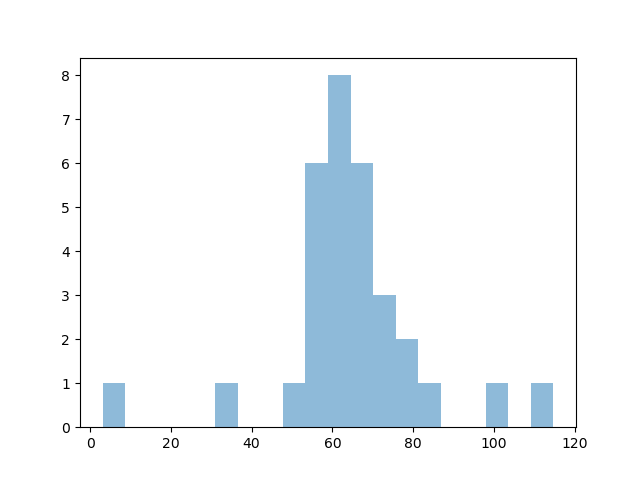

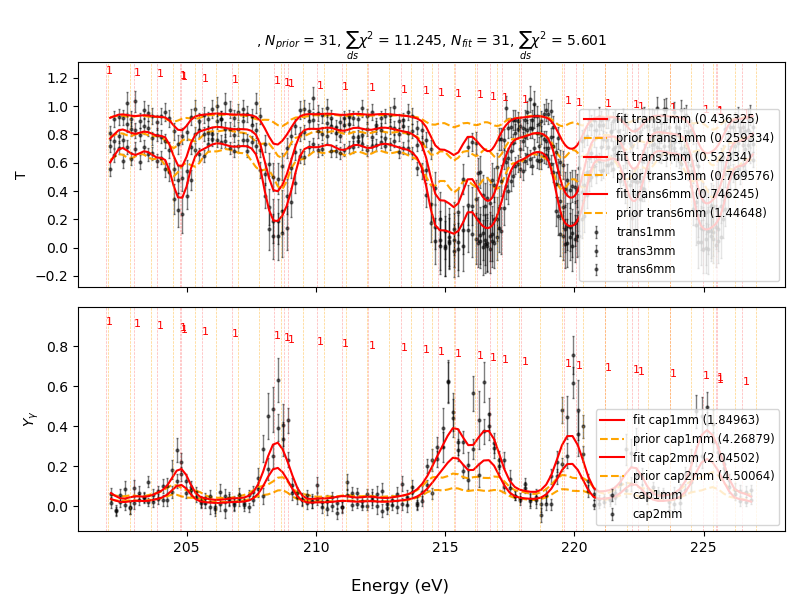

In [15]:
import matplotlib.pyplot as plt
figure()
# _ = plt.hist(np.log10(sammyOUT_initialFB.par_post.Gn1), bins=20, label="Gn1")
_= plt.hist(sammyOUT_initialFB.par_post.Gg, bins=20, label="Gg", alpha=0.5)

fig = plot_datafits(datasets, experiments, 
    fits=sammyOUT_initialFB.pw_post,
    fit_pars=sammyOUT_initialFB.par_post,
    fits_chi2=sammyOUT_initialFB.chi2n_post,
    priors=sammyOUT_initialFB.pw,
    prior_pars = sammyOUT_initialFB.par,
    priors_chi2= sammyOUT_initialFB.chi2n
)

fig.tight_layout()

In [16]:
import importlib
from ATARI.AutoFit import chi2_eliminator_v2, elim_addit_funcs

importlib.reload(chi2_eliminator_v2)


start_ladder =  sammyOUT_initialFB.par_post #true_ladder#
assert isinstance(start_ladder, pd.DataFrame)
start_ladder['varyGg'] = np.zeros(len(start_ladder))

# side resonances if needed, otherways - keep empty
side_resonances_df = pd.DataFrame()

side_resonances_df = elim_addit_funcs.find_side_res_df(
        initial_sol_df = jeff_parameters,
        energy_region = energy_range_all,
        N_res = 2
)

side_resonances_df = elim_addit_funcs.set_varying_fixed_params(ladder_df=side_resonances_df,
                                                               vary_list=[0,1,1])
print(side_resonances_df)

# compiling to one ladder

start_ladder = pd.concat([side_resonances_df, start_ladder], ignore_index=True)
start_ladder

         E       Gg      Gn1  varyE  varyGg  varyGn1  J_ID
47  200.00  63.0000  31.4285      0       1        1   1.0
55  230.62  64.9999  22.4200      0       1        1   2.0


,E,Gg,Gn1,varyE,varyGg,varyGn1,J_ID
0,200.000000,63.000000,31.428500,0.0,1.0,1.0,1.0
1,230.620000,64.999900,22.420000,0.0,1.0,1.0,2.0
2,201.882669,70.887452,0.745013,1.0,0.0,1.0,1.0
3,202.964562,82.378462,0.373475,1.0,0.0,1.0,1.0
4,203.831758,67.880815,0.377349,1.0,0.0,1.0,1.0
5,204.722834,54.075581,1.536241,1.0,0.0,1.0,1.0
6,204.787870,53.500417,0.936188,1.0,0.0,1.0,1.0
7,205.581057,55.976568,0.182009,1.0,0.0,1.0,1.0
8,206.750772,55.853923,0.102085,1.0,0.0,1.0,1.0
9,208.359536,56.115572,3.811973,1.0,0.0,1.0,1.0


In [17]:

# side resonances - keep empty
# side_resonances_df = pd.DataFrame()

# defining rto & inputs

elim_sammyINPyw = sammy_classes.SammyInputDataYW(
    particle_pair = Ta_pair,
    resonance_ladder = start_ladder,

    datasets = datasets,
    experimental_covariance=covariance_data,
    experiments = experiments,

    max_steps = 5,
    iterations = 3,
    step_threshold = 0.01,
    autoelim_threshold = None,

    LS = False,
    LevMar = True,
    LevMarV = 1.5,

    minF = 1e-5,
    maxF = 10,
    initial_parameter_uncertainty = 0.05
    )

# defining the elim_opts
elim_opts = chi2_eliminator_v2.elim_OPTs(chi2_allowed = 100,
                                      fixed_resonances_df = side_resonances_df,
                                      deep_fit_max_iter = 5,
                                      deep_fit_step_thr = 0.1,
                                      start_fudge_for_deep_stage = 0.05,
                                      )

elimi = chi2_eliminator_v2.eliminator_by_chi2(rto=sammy_rto_fit,
                                            sammyINPyw = elim_sammyINPyw , 
                                            options = elim_opts
                            )

history = elimi.eliminate(ladder_df=start_ladder)

****************************************
Elimination cycle printout enabled
****************************************

Chi2 thresold applied for model selection: 100


Input ladder:
             E          Gg        Gn1  varyE  varyGg  varyGn1  J_ID
0   200.000000   63.000000  31.428500    0.0     1.0      1.0   1.0
1   230.620000   64.999900  22.420000    0.0     1.0      1.0   2.0
2   201.882669   70.887452   0.745013    1.0     0.0      1.0   1.0
3   202.964562   82.378462   0.373475    1.0     0.0      1.0   1.0
4   203.831758   67.880815   0.377349    1.0     0.0      1.0   1.0
5   204.722834   54.075581   1.536241    1.0     0.0      1.0   1.0
6   204.787870   53.500417   0.936188    1.0     0.0      1.0   1.0
7   205.581057   55.976568   0.182009    1.0     0.0      1.0   1.0
8   206.750772   55.853923   0.102085    1.0     0.0      1.0   1.0
9   208.359536   56.115572   3.811973    1.0     0.0      1.0   1.0
10  208.754705   57.442773   1.682762    1.0     0.0      1.0   1.0
11 

Eliminated from 33 res -> 9


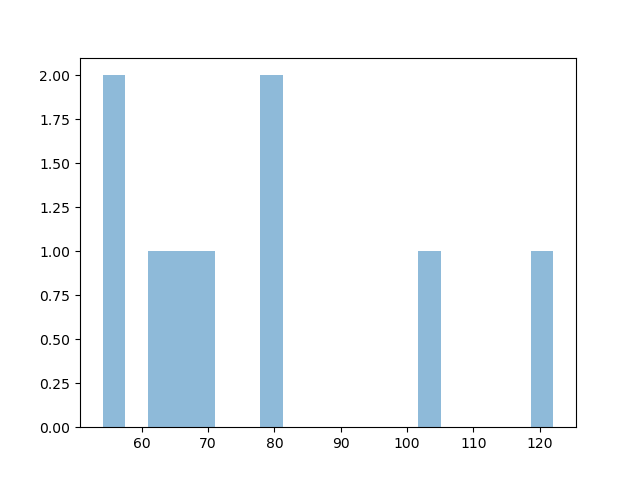

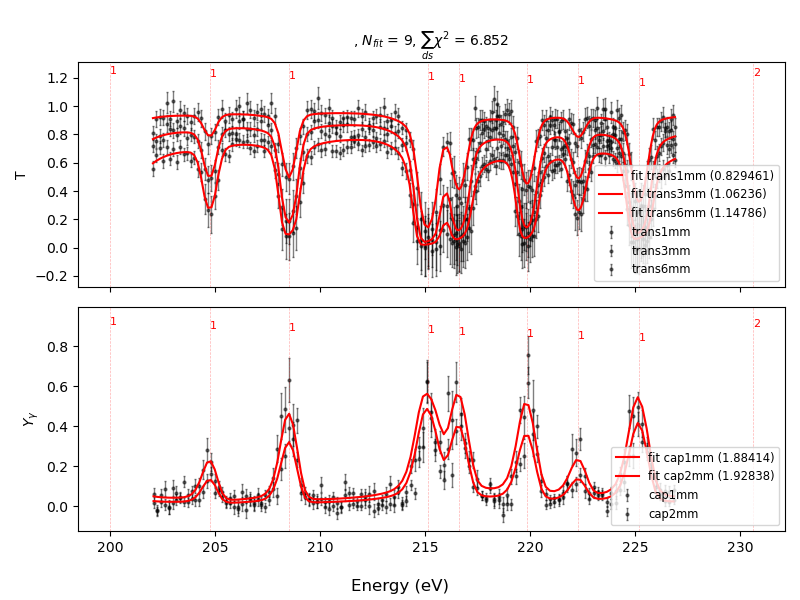

In [124]:
print(f'Eliminated from {history.ladder_IN.shape[0]} res -> {history.ladder_OUT.shape[0]}')
minkey = min(history.elimination_history.keys())

sammyOUT_elim = history.elimination_history[minkey+1]['selected_ladder_chars']

figure()
# _ = plt.hist(np.log10(sammyOUT_elim.par_post.Gn1), bins=20, label="Gn1")
_= plt.hist(sammyOUT_elim.par_post.Gg, bins=20, label="Gg", alpha=0.5)

fig = plot_datafits(datasets, experiments, 
    fits=sammyOUT_elim.pw_post, 
    fits_chi2=sammyOUT_elim.chi2n_post,
    priors=[], priors_chi2=[],
    # true=datasets, 
    true_chi2=[],
    # true_pars = true_ladder, 
    # prior_pars = pd.DataFrame(),
    fit_pars = sammyOUT_elim.par_post,
    # title: str = '',
    show_spingroups = True,
    fig_size = (8,6)
)

fig.tight_layout()

In [146]:
# # plot the final selected fit?
# # images production from history

# prior_level = max(history.elimination_history.keys())
# prior_numres = history.elimination_history[prior_level]['input_ladder'].shape[0]
# print(f'Initial ladder, num of res.: {prior_numres}')

# min_level_passed_test = prior_level # level - key in the hist..
# min_N_res_passed_test = prior_level - 1

# levels = []
# N_ress = []
# chi2_s = []

# for level in history.elimination_history.keys():
        
#     numres = history.elimination_history[level]['selected_ladder_chars'].par_post.shape[0]
#     pass_test = history.elimination_history[level]['final_model_passed_test']

#     #print(f'level {level}, # of resonances: {numres},  passed the test: {pass_test}')

#     if (pass_test and level<min_level_passed_test):
#         min_level_passed_test = level

#         min_N_res_passed_test = numres
    
#     levels.append(level)
#     chi2_s.append(np.sum(history.elimination_history[level]['selected_ladder_chars'].chi2_post))
#     N_ress.append(numres)

# # plotting    

# # differences in chi2 values between 2 models
# chi2_diffs = np.diff(chi2_s, prepend=chi2_s[0]) 

# fig, (ax1, ax2) = subplots(2, 1, figsize = fig_size, sharex=True, gridspec_kw={'height_ratios': [2, 1]})

# # First subplot for the original chi2 values
# ax1.plot(N_ress, chi2_s, marker='o')
# ax1.axvline(x=min_N_res_passed_test, color='r', linestyle='--')

# ax1.set_ylabel('$\chi^2$')
# ax1.grid(True)

# # changes in chi2

# ax2.plot(N_ress, chi2_diffs, marker='o', color='green')
# ax2.axvline(x=min_N_res_passed_test, color='r', linestyle='--')
# ax2.set_xlabel(r'$N_{res}$')
# ax2.set_ylabel('Change in $\chi^2$')
# ax2.invert_xaxis()
# ax2.grid(True)

# tight_layout()
# fig.savefig(savefolder+'hist_png', dpi=75)
# show()

In [131]:
# fixed_resonances_indices = [0,1]
# in_window_df = copy(sammyOUT_elim.par_post)
# print(in_window_df)
# fixed_resonances_df = in_window_df.iloc[fixed_resonances_indices, :]
# in_window_df.drop(index = fixed_resonances_indices, inplace=True)
# print(fixed_resonances_df)
# print(in_window_df)
# pd.concat([fixed_resonances_df, in_window_df])


            E          Gg        Gn1  varyE  varyGg  varyGn1  J_ID
0  200.000000   65.126499  78.927403    0.0     1.0      1.0   1.0
1  230.620000  122.086191   8.642578    0.0     1.0      1.0   2.0
2  204.739749   54.075581   3.173397    1.0     0.0      1.0   1.0
3  208.524276   57.442773  12.454658    1.0     0.0      1.0   1.0
4  215.127533   78.994529  50.006951    1.0     0.0      1.0   1.0
5  216.620305  103.291985  17.196243    1.0     0.0      1.0   1.0
6  219.862622   70.570667  15.422468    1.0     0.0      1.0   1.0
7  222.302794   61.647417   3.415264    1.0     0.0      1.0   1.0
8  225.205759   78.575612  25.490053    1.0     0.0      1.0   1.0
        E          Gg        Gn1  varyE  varyGg  varyGn1  J_ID
0  200.00   65.126499  78.927403    0.0     1.0      1.0   1.0
1  230.62  122.086191   8.642578    0.0     1.0      1.0   2.0
            E          Gg        Gn1  varyE  varyGg  varyGn1  J_ID
2  204.739749   54.075581   3.173397    1.0     0.0      1.0   1.0
3  208.

,E,Gg,Gn1,varyE,varyGg,varyGn1,J_ID
0,200.000000,65.126499,78.927403,0.0,1.0,1.0,1.0
1,230.620000,122.086191,8.642578,0.0,1.0,1.0,2.0
2,204.739749,54.075581,3.173397,1.0,0.0,1.0,1.0
3,208.524276,57.442773,12.454658,1.0,0.0,1.0,1.0
4,215.127533,78.994529,50.006951,1.0,0.0,1.0,1.0
5,216.620305,103.291985,17.196243,1.0,0.0,1.0,1.0
6,219.862622,70.570667,15.422468,1.0,0.0,1.0,1.0
7,222.302794,61.647417,3.415264,1.0,0.0,1.0,1.0
8,225.205759,78.575612,25.490053,1.0,0.0,1.0,1.0


In [138]:
# sammyOUT_elim.par_post['varyGg'] = np.ones(len(sammyOUT_elim.par_post))
# sammyOUT_elim.par_post

,E,Gg,Gn1,varyE,varyGg,varyGn1,J_ID
0,200.000000,65.126499,78.927403,0.0,1.0,1.0,1.0
1,230.620000,122.086191,8.642578,0.0,1.0,1.0,2.0
2,204.739749,54.075581,3.173397,1.0,1.0,1.0,1.0
3,208.524276,57.442773,12.454658,1.0,1.0,1.0,1.0
4,215.127533,78.994529,50.006951,1.0,1.0,1.0,1.0
5,216.620305,103.291985,17.196243,1.0,1.0,1.0,1.0
6,219.862622,70.570667,15.422468,1.0,1.0,1.0,1.0
7,222.302794,61.647417,3.415264,1.0,1.0,1.0,1.0
8,225.205759,78.575612,25.490053,1.0,1.0,1.0,1.0


In [162]:
import pickle
from ATARI.AutoFit import spin_group_selection
importlib.reload(spin_group_selection)

spinselectOPT = spin_group_selection.SpinSelectOPT(step_threshold=0.01,
                                                    max_steps=10,
                                                    LevMarV0 = 0.1)
spinselector = spin_group_selection.SpinSelect(spinselectOPT)



for i in range(9,13):
    elim_out = history.elimination_history[i]['selected_ladder_chars']

    fixed_resonances_indices = [0,1]
    # in_window_df = copy(elim_out.par_post)
    # fixed_resonances_df = in_window_df.iloc[fixed_resonances_indices, :]
    # in_window_df.drop(index = fixed_resonances_indices, inplace=True)
    # print(fixed_resonances_df)
    # print(in_window_df)
    # pd.concat([fixed_resonances_df, in_window_df])

    
    sammyOUT_elim.par_post['varyGg'] = np.ones(len(sammyOUT_elim.par_post))
    sammyOUT_elim.par_post


    sammyOUT_spin = spinselector.get_best_chi2([1.0,2.0],
                                                elim_out.par_post, #sammyOUT_elim.par_post,
                                                Ta_pair,
                                                datasets,
                                                experiments,
                                                covariance_data,
                                                sammy_rto_fit,
                                                fixed_resonances_indices = fixed_resonances_indices)


    file = open(f'./spin_model_{i}.pkl', 'wb')
    pickle.dump(sammyOUT_spin, file)
    file.close()

Stepping until convergence
chi2 values
step fudge: ['cap1mm', 'cap2mm', 'trans1mm', 'trans3mm', 'trans6mm', 'sum']
0    0.1  : [2.1779, 2.4376, 0.9332, 2.5499, 4.8327, 12.9314]
Repeat step 1, 	fudge: ['cap1mm', 'cap2mm', 'trans1mm', 'trans3mm', 'trans6mm', 'sum']
		0.02 : [2.1779, 2.4376, 0.9332, 2.5502, 4.8325, 12.9314]
		0.004: [2.1779, 2.4376, 0.9332, 2.55, 4.8327, 12.9314]
1    0.004: [2.1779, 2.4376, 0.9332, 2.55, 4.8327, 12.9314]
Chi2 improvement below threshold
Stepping until convergence
chi2 values
step fudge: ['cap1mm', 'cap2mm', 'trans1mm', 'trans3mm', 'trans6mm', 'sum']
0    0.1  : [2.1779, 2.4376, 0.9332, 2.5499, 4.8327, 12.9314]
Repeat step 1, 	fudge: ['cap1mm', 'cap2mm', 'trans1mm', 'trans3mm', 'trans6mm', 'sum']
		0.02 : [2.1779, 2.4376, 0.9332, 2.5502, 4.8325, 12.9314]
		0.004: [2.1779, 2.4376, 0.9332, 2.55, 4.8327, 12.9314]
1    0.004: [2.1779, 2.4376, 0.9332, 2.55, 4.8327, 12.9314]
Chi2 improvement below threshold
Stepping until convergence
chi2 values
step fudge: ['c

[1.88414, 1.92838, 0.829461, 1.06236, 1.14786] 6.852201000000001
[1.49365, 1.61553, 0.937598, 1.01204, 1.11709] 6.175908
            E          Gg        Gn1  varyE  varyGg  varyGn1  J_ID
0  200.000000   65.126499  78.927403    0.0     1.0      1.0   1.0
1  230.620000  122.086191   8.642578    0.0     1.0      1.0   2.0
2  204.739749   54.075581   3.173397    1.0     1.0      1.0   1.0
3  208.524276   57.442773  12.454658    1.0     1.0      1.0   1.0
4  215.127533   78.994529  50.006951    1.0     1.0      1.0   1.0
5  216.620305  103.291985  17.196243    1.0     1.0      1.0   1.0
6  219.862622   70.570667  15.422468    1.0     1.0      1.0   1.0
7  222.302794   61.647417   3.415264    1.0     1.0      1.0   1.0
8  225.205759   78.575612  25.490053    1.0     1.0      1.0   1.0
            E          Gg        Gn1  varyE  varyGg  varyGn1  J_ID
0  204.737279   31.888447   3.143910    1.0     1.0      1.0   1.0
1  208.515967   48.547931  13.525729    1.0     1.0      1.0   1.0
2  215.1

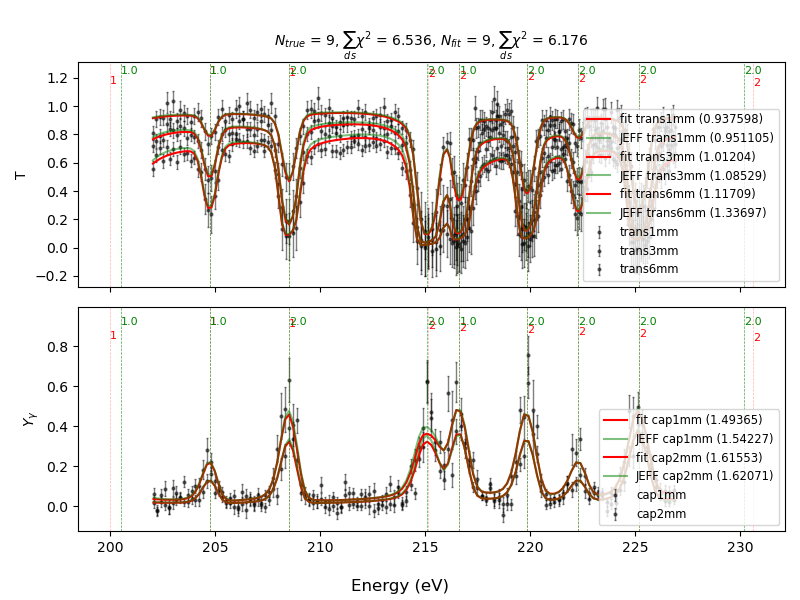

In [145]:
print(sammyOUT_elim.chi2n_post, np.sum(sammyOUT_elim.chi2n_post))
print(sammyOUT_spin.chi2n_post, np.sum(sammyOUT_spin.chi2n_post))
print(sammyOUT_elim.par_post)
print(sammyOUT_spin.par_post)
fig = plot_datafits(datasets, experiments, 
    fits=sammyOUT_spin.pw_post, 
    fits_chi2=sammyOUT_spin.chi2n_post,
    priors=[], priors_chi2=[],
    true=sammyOUT.pw_post, 
    true_chi2= sammyOUT.chi2n_post,
    true_pars = sammyOUT.par_post, 
    # prior_pars = sammyOUT_elim.par_post,
    fit_pars = sammyOUT_spin.par_post,
    # title: str = '',
    show_spingroups = True,
    fig_size = (8,6)
)

fig.tight_layout()

In [65]:
print(sammyOUT.par_post)

            E          Gg        Gn1  varyE  varyGg  varyGn1  J_ID
0  200.516767   44.435433  51.772589    1.0     1.0      1.0   1.0
1  204.736422   43.069631   3.097519    1.0     1.0      1.0   1.0
2  208.528983   49.763403  10.209657    1.0     1.0      1.0   2.0
3  215.113313   35.766896  56.804140    1.0     1.0      1.0   2.0
4  216.638353   41.083458  19.013649    1.0     1.0      1.0   1.0
5  219.862871   25.402898  13.644280    1.0     1.0      1.0   2.0
6  222.306252   29.162177   2.588519    1.0     1.0      1.0   2.0
7  225.206622   36.070372  23.475279    1.0     1.0      1.0   2.0
8  230.208494  100.621633  27.895448    1.0     1.0      1.0   2.0


In [62]:
test_ladder = copy(sammyOUT_spin.par_post)
print(test_ladder)
test_ladder.loc[3,"J_ID"] = 1.0
print(test_ladder)

            E          Gg       Gn1  varyE  varyGg  varyGn1  J_ID
0  204.716353  402.955670  2.432851    1.0     1.0      1.0   2.0
1  208.526273  278.039815  4.766820    1.0     1.0      1.0   2.0
2  215.150055  632.045967  8.753457    1.0     1.0      1.0   2.0
3  216.657607  405.583827  5.898217    1.0     1.0      1.0   2.0
4  219.882560  280.550200  5.794011    1.0     1.0      1.0   2.0
5  222.298461   80.810444  1.958797    1.0     1.0      1.0   2.0
6  225.237512  404.196310  8.086624    1.0     1.0      1.0   2.0
            E          Gg       Gn1  varyE  varyGg  varyGn1  J_ID
0  204.716353  402.955670  2.432851    1.0     1.0      1.0   2.0
1  208.526273  278.039815  4.766820    1.0     1.0      1.0   2.0
2  215.150055  632.045967  8.753457    1.0     1.0      1.0   2.0
3  216.657607  405.583827  5.898217    1.0     1.0      1.0   1.0
4  219.882560  280.550200  5.794011    1.0     1.0      1.0   2.0
5  222.298461   80.810444  1.958797    1.0     1.0      1.0   2.0
6  225.237

In [64]:
sammyINPyw.resonance_ladder = test_ladder
sammyINPyw.step_threshold = 0.01
sammyOUT_test = sammy_functions.run_sammy_YW(sammyINPyw, rto)

Stepping until convergence
chi2 values
step fudge: ['cap1mm', 'cap2mm', 'trans1mm', 'trans3mm', 'trans6mm', 'sum']
0    0.01 : [2.1157, 2.3949, 0.3853, 1.0572, 1.8965, 7.8496]
1    0.02 : [2.0896, 2.3805, 0.3845, 1.0419, 1.8484, 7.7449]
2    0.04 : [2.0963, 2.3875, 0.3793, 0.9705, 1.797, 7.6305]
3    0.08 : [2.1068, 2.3986, 0.382, 0.9054, 1.7516, 7.5446]
Repeat step 4, 	fudge: ['cap1mm', 'cap2mm', 'trans1mm', 'trans3mm', 'trans6mm', 'sum']
		0.016: [2.1084, 2.4003, 0.3831, 0.9, 1.748, 7.5398]
4    0.016: [2.1084, 2.4003, 0.3831, 0.9, 1.748, 7.5398]
Chi2 improvement below threshold


### Next steps

Before giving this to oleksii for AIC, I could fit background with external resonances
1. fix the result above
2. add external resonances on either side of the window with fixed energies
3. Fit external resonance widths to capture background
4. give results to Oleksii where AIC will eliminate and re-fit all internal resonance parameters and only widths of external resonances


In [153]:
import pickle

# open a file, where you ant to store the data
file = open('./initialFB.pkl', 'wb')
pickle.dump(start_ladder, file)
file.close()

for i in range(9,13):
    obj = history.elimination_history[i]['selected_ladder_chars']
    file = open(f'./elim_{i}.pkl', 'wb')
    pickle.dump(obj, file)
    file.close()
    
# for i in range(9,12):
#     obj = history.elimination_history[i]['selected_ladder_chars']
# # file = open('./spin_group.pkl', 'wb')
# # pickle.dump(start_ladder, file)
# # file.close()

In [163]:
file = open('./spin_model_12.pkl', 'rb')
fbout = pickle.load(file)
file.close()

In [165]:
fbout.par_post

,E,Gg,Gn1,varyE,varyGg,varyGn1,J_ID
0,204.741872,54.075581,2.348920,1.0,0.0,1.0,2.0
1,208.522334,57.442773,8.921431,1.0,0.0,1.0,2.0
2,214.831151,3.060050,10.774297,1.0,0.0,1.0,1.0
3,215.294030,78.994529,21.835185,1.0,0.0,1.0,1.0
4,216.627523,103.291985,17.032382,1.0,0.0,1.0,1.0
5,219.761676,32.482910,7.020997,1.0,0.0,1.0,1.0
6,219.971992,70.570667,6.961697,1.0,0.0,1.0,1.0
7,222.304332,61.647417,2.630040,1.0,0.0,1.0,2.0
8,225.208830,78.575612,23.435459,1.0,0.0,1.0,1.0
9,200.000000,64.998137,67.145788,0.0,1.0,1.0,1.0
